In [5]:
# ===============================
# RANDOM FOREST REGRESSION (Complete: Beginner → Advanced)
# ===============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

import shap
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

In [6]:
# -----------------------------
# 1) Load dataset (California Housing — regression task)
# -----------------------------
data = fetch_california_housing(as_frame=True)
df = data.frame
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (20640, 9)
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


In [7]:
# -----------------------------
# 2) Train-test split
# -----------------------------
X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE)

print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)


Train: (14448, 8) Valid: (3096, 8) Test: (3096, 8)


In [10]:

# -----------------------------
# 3) Preprocessing
# -----------------------------
num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = X.select_dtypes(exclude=np.number).columns.tolist()

num_pre = Pipeline([
    ("scaler", StandardScaler())
])

cat_pre = Pipeline([
    ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pre, num_features),
    ("cat", cat_pre, cat_features)
])



In [11]:
# -----------------------------
# 4) Basic Random Forest Model
# -----------------------------
rf_basic = Pipeline([
    ("pre", preprocessor),
    ("rf", RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=100))
])

rf_basic.fit(X_train, y_train)
y_pred_basic = rf_basic.predict(X_valid)

print("\n[Basic Random Forest Regression]")
print("MAE:", mean_absolute_error(y_valid, y_pred_basic))
print("RMSE:", mean_squared_error(y_valid, y_pred_basic, squared=False))
print("R²:", r2_score(y_valid, y_pred_basic))



[Basic Random Forest Regression]
MAE: 0.33865197855297174
RMSE: 0.5198483817596442
R²: 0.7925629217891738


In [12]:
# -----------------------------
# 5) Cross-validation
# -----------------------------
cv_scores = cross_val_score(rf_basic, X_train, y_train, cv=5, scoring="r2")
print("\nCross-Validation R² scores:", cv_scores)
print("Mean CV R²:", np.mean(cv_scores))



Cross-Validation R² scores: [0.79801222 0.78218619 0.80527771 0.8035355  0.80234951]
Mean CV R²: 0.7982722270456091


In [13]:
# -----------------------------
# 6) Hyperparameter Tuning
# -----------------------------
param_grid = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_split": [2, 5],
    "rf__min_samples_leaf": [1, 2],
    "rf__max_features": ["auto", "sqrt"]
}

grid = GridSearchCV(rf_basic, param_grid, cv=3, scoring="r2", n_jobs=-1)
grid.fit(X_train, y_train)

print("\nBest Params (GridSearch):", grid.best_params_)
print("Best CV R²:", grid.best_score_)

best_rf = grid.best_estimator_



Best Params (GridSearch): {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best CV R²: 0.8070534924741258


In [14]:
# -----------------------------
# 7) Final Evaluation
# -----------------------------
y_test_pred = best_rf.predict(X_test)

print("\n[Final Random Forest on Test Set]")
print("MAE:", mean_absolute_error(y_test, y_test_pred))
print("RMSE:", mean_squared_error(y_test, y_test_pred, squared=False))
print("R²:", r2_score(y_test, y_test_pred))



[Final Random Forest on Test Set]
MAE: 0.3224789731912147
RMSE: 0.4795293383722003
R²: 0.8261010556451612



Top Feature Importances:
 MedInc        0.359100
Latitude      0.132072
Longitude     0.129744
AveOccup      0.123626
AveRooms      0.115878
HouseAge      0.056498
AveBedrms     0.047113
Population    0.035969
dtype: float64


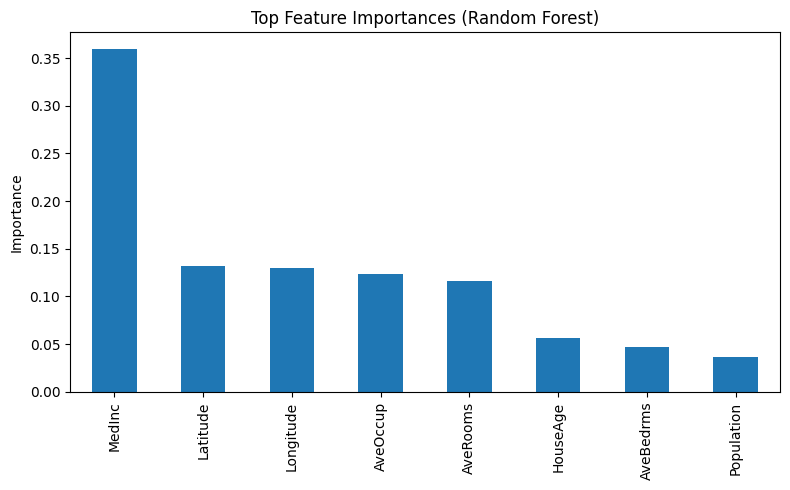

In [15]:
# -----------------------------
# 8) Feature Importance
# -----------------------------
# Get feature names after preprocessing
oh = best_rf.named_steps["pre"].named_transformers_["cat"].named_steps["oh"] if cat_features else None
cat_names = list(oh.get_feature_names_out(cat_features)) if oh else []
feature_names = num_features + cat_names

importances = best_rf.named_steps["rf"].feature_importances_
imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("\nTop Feature Importances:\n", imp.head(10))

plt.figure(figsize=(8,5))
imp.head(15).plot(kind="bar")
plt.ylabel("Importance")
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


Top Permutation Importances:
 MedInc        0.503898
Latitude      0.333718
Longitude     0.271214
AveOccup      0.169655
AveRooms      0.057310
HouseAge      0.051316
AveBedrms     0.006779
Population    0.005114
dtype: float64


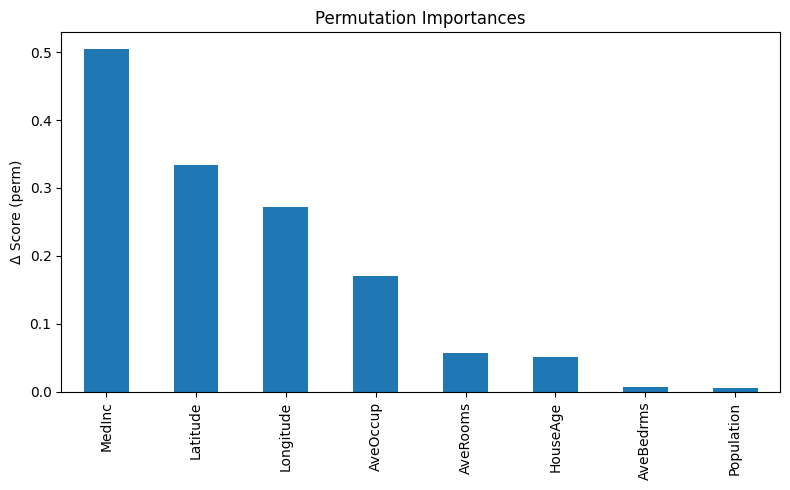

In [16]:
# -----------------------------
# 9) Permutation Importance
# -----------------------------
perm = permutation_importance(best_rf, X_valid, y_valid, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False)

print("\nTop Permutation Importances:\n", perm_imp.head(10))

plt.figure(figsize=(8,5))
perm_imp.head(15).plot(kind="bar")
plt.ylabel("Δ Score (perm)")
plt.title("Permutation Importances")
plt.tight_layout()
plt.show()


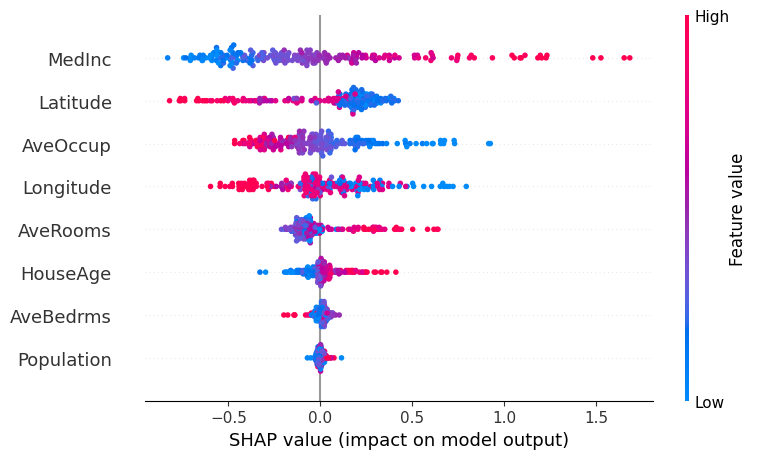

In [17]:
# -----------------------------
# 10) SHAP Values (Advanced Explainability)
# -----------------------------
explainer = shap.TreeExplainer(best_rf.named_steps["rf"])
shap_values = explainer.shap_values(best_rf.named_steps["pre"].transform(X_valid)[:200])  # subset for speed

shap.summary_plot(shap_values, best_rf.named_steps["pre"].transform(X_valid)[:200], feature_names=feature_names)
